In [2]:
import torch
import torch.nn
import math
import logging
LOG_FORMAT = "%(asctime)s [%(levelname)s] %(message)s"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT, datefmt=DATE_FORMAT)
from model import Perceptron
import easydict
from main import amp, se, replica
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
args = easydict.EasyDict({
    "N": 10000,
    "P": 20
})
args["alphas"] = args.P / args.N

In [3]:
teacher = Perceptron(args).to(device)
student = Perceptron(args).to(device)
testX = torch.normal(0, 1, size=(10000, args.N), device=device)
alphaLists = torch.arange(0.1, 4.01, 0.1)
record = {
    "error": []
}
for alpha in alphaLists:
    args.P = int(args.N * alpha)
    record["error"].append([])
    for _ in range(20):
        trainX = torch.normal(0, 1, size=(args.P, args.N), device=device)
        yhat = teacher(trainX)
        student.resetParameters()
        What, V, flag = amp((trainX, yhat), device, args)
        if flag:
            student.weight = What.clone()
            yhat = teacher(testX)
            y = student(testX)
            e = 1 - torch.sum(y == yhat).item() / 10000
            logging.info(f"P: {args.P}, error: {e:.2%}")
            record["error"][-1].append(e)
        else:
            logging.info("AMP fails")
        if len(record["error"][-1]) >= 5:
            break
record["alpha"] = alphaLists
torch.save(record, "./Data/records/amp.pt")

2023-06-04 15:55:42 [INFO] P: 1000, error: 41.84%
2023-06-04 15:55:42 [INFO] P: 1000, error: 41.86%
2023-06-04 15:55:42 [INFO] P: 1000, error: 42.18%
2023-06-04 15:55:42 [INFO] P: 1000, error: 41.91%
2023-06-04 15:55:42 [INFO] P: 1000, error: 41.60%
2023-06-04 15:55:42 [INFO] P: 2000, error: 39.04%
2023-06-04 15:55:42 [INFO] P: 2000, error: 37.94%
2023-06-04 15:55:42 [INFO] P: 2000, error: 38.95%
2023-06-04 15:55:42 [INFO] P: 2000, error: 38.36%
2023-06-04 15:55:42 [INFO] P: 2000, error: 39.29%
2023-06-04 15:55:42 [INFO] P: 3000, error: 36.07%
2023-06-04 15:55:42 [INFO] P: 3000, error: 35.68%
2023-06-04 15:55:42 [INFO] P: 3000, error: 36.27%
2023-06-04 15:55:42 [INFO] P: 3000, error: 35.97%
2023-06-04 15:55:42 [INFO] P: 3000, error: 36.82%
2023-06-04 15:55:42 [INFO] P: 4000, error: 35.35%
2023-06-04 15:55:42 [INFO] P: 4000, error: 34.49%
2023-06-04 15:55:42 [INFO] P: 4000, error: 33.14%
2023-06-04 15:55:42 [INFO] P: 4000, error: 33.70%
2023-06-04 15:55:42 [INFO] P: 4000, error: 34.45%


In [4]:
logging.getLogger().setLevel(logging.INFO)
alphaLists = torch.arange(0.1, 4.01, 0.01)
record = easydict.EasyDict({
    "error": []
})
initialM = None
for alpha in alphaLists:
    args.P = int(args.N * alpha)
    args["alphas"] = alpha

    m, mhat, q, e, flag = se(device, args, initialM=initialM)
    
    if flag:
        logging.info(f"P: {args.P}, error: {e:.2%}")
        record["error"].append(e)
        initialM = [m, mhat]
    else:
        logging.info("SE fails")
record.alpha = alphaLists
torch.save(record, "./Data/records/se.pt")

2023-06-04 15:56:42 [INFO] P: 1000, error: 42.17%
2023-06-04 15:56:42 [INFO] P: 1100, error: 41.83%
2023-06-04 15:56:43 [INFO] P: 1200, error: 41.48%
2023-06-04 15:56:43 [INFO] P: 1300, error: 41.14%
2023-06-04 15:56:43 [INFO] P: 1400, error: 40.81%
2023-06-04 15:56:43 [INFO] P: 1500, error: 40.50%
2023-06-04 15:56:44 [INFO] P: 1600, error: 40.19%
2023-06-04 15:56:44 [INFO] P: 1700, error: 39.90%
2023-06-04 15:56:44 [INFO] P: 1800, error: 39.62%
2023-06-04 15:56:44 [INFO] P: 1900, error: 39.34%
2023-06-04 15:56:44 [INFO] P: 2000, error: 39.08%
2023-06-04 15:56:45 [INFO] P: 2100, error: 38.82%
2023-06-04 15:56:45 [INFO] P: 2200, error: 38.56%
2023-06-04 15:56:45 [INFO] P: 2300, error: 38.30%
2023-06-04 15:56:45 [INFO] P: 2400, error: 38.07%
2023-06-04 15:56:46 [INFO] P: 2500, error: 37.83%
2023-06-04 15:56:46 [INFO] P: 2600, error: 37.59%
2023-06-04 15:56:46 [INFO] P: 2699, error: 37.36%
2023-06-04 15:56:46 [INFO] P: 2800, error: 37.14%
2023-06-04 15:56:47 [INFO] P: 2900, error: 36.93%


In [3]:
logging.getLogger().setLevel(logging.INFO)
torch.set_default_dtype(torch.float64)
alphaLists = torch.arange(0.1, 4.01, 0.01)
record = easydict.EasyDict({
    "error": []
})
initialQ = None
for alpha in alphaLists:
    args.P = int(args.N * alpha)
    args["alphas"] = alpha

    for _ in range(20):
        q, qhat, e, flag = replica(device, args, initialQ=initialQ)
        
        if flag:
            logging.info(f"P: {args.P}, error: {e:.2%}")
            record["error"].append(e)
            initialQ = [q, qhat]
            break
        else:
            initialQ = None
            logging.info("Replica fails")

record.alpha = alphaLists
torch.save(record, "./Data/records/replica.pt")

2023-06-04 16:50:48 [INFO] P: 1000, error: 41.99%
2023-06-04 16:50:48 [INFO] P: 1100, error: 41.62%
2023-06-04 16:50:49 [INFO] P: 1200, error: 41.23%
2023-06-04 16:50:49 [INFO] P: 1300, error: 40.87%
2023-06-04 16:50:50 [INFO] P: 1400, error: 40.52%
2023-06-04 16:50:50 [INFO] P: 1500, error: 40.20%
2023-06-04 16:50:51 [INFO] P: 1600, error: 39.88%
2023-06-04 16:50:51 [INFO] P: 1700, error: 39.57%
2023-06-04 16:50:52 [INFO] P: 1800, error: 39.28%
2023-06-04 16:50:52 [INFO] P: 1900, error: 38.99%
2023-06-04 16:50:53 [INFO] P: 1999, error: 38.71%
2023-06-04 16:50:53 [INFO] P: 2100, error: 38.42%
2023-06-04 16:50:54 [INFO] P: 2200, error: 38.16%
2023-06-04 16:50:54 [INFO] P: 2300, error: 37.91%
2023-06-04 16:50:55 [INFO] P: 2400, error: 37.61%
2023-06-04 16:50:55 [INFO] P: 2500, error: 37.40%
2023-06-04 16:50:56 [INFO] P: 2600, error: 37.13%
2023-06-04 16:50:56 [INFO] P: 2700, error: 36.88%
2023-06-04 16:50:57 [INFO] P: 2800, error: 36.66%
2023-06-04 16:50:57 [INFO] P: 2900, error: 36.42%


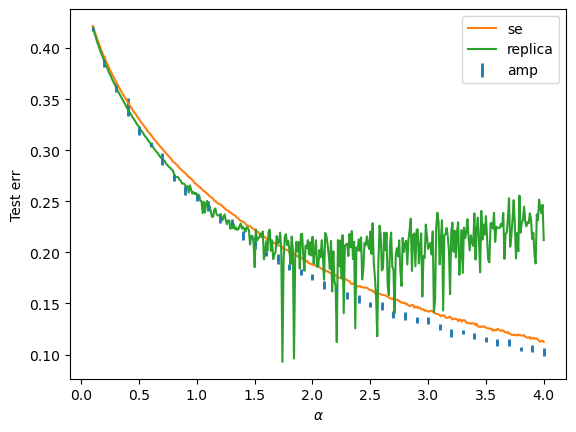

In [5]:
logging.getLogger().setLevel(logging.INFO)
record = torch.load("./Data/records/amp.pt")
ampError = torch.tensor(easydict.EasyDict(record).error)
# alphaLists1 = record["alpha"]
alphaLists1 = torch.arange(0.1, 4.01, 0.1)
record = torch.load("./Data/records/se.pt")
seError = torch.tensor(record.error)
alphaLists2 = torch.arange(0.1, 4.01, 0.01)
record = torch.load("./Data/records/replica.pt")
replicaError = torch.tensor(record.error)
alphaLists3 = torch.arange(0.1, 4.01, 0.01)

ampErrorStd, ampErrorMean = torch.std_mean(ampError, dim=1)
plt.errorbar(alphaLists1, ampErrorMean, ampErrorStd, fmt="o", markersize=1, elinewidth=2, label="amp")
plt.plot(alphaLists2, seError, label="se")
plt.plot(alphaLists3, replicaError, label="replica")
plt.xlabel("$\\alpha$")
plt.ylabel("Test err")
plt.legend()
plt.savefig(f"./Data/figures/perceptron.pdf")
plt.show()
plt.close()